<a href="https://colab.research.google.com/github/yilewang/TVB_Demo/blob/master/sim1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install tvb-library
%pylab inline
import os
from tvb.simulator.lab import *
LOG = get_logger('demo')
import pickle as cPickle
from tvb.simulator.models.stefanescu_jirsa import ReducedSetHindmarshRose


In [2]:
%%capture
! wget -c -O 0306A.zip --no-check-certificate https://github.com/yilewang/TVB_Demo/raw/master/0306A.zip
path = os.path.abspath("0306A.zip")
print(path)

In [3]:
connectivity.speed = np.array([10.])
sim = simulator.Simulator(
    model=ReducedSetHindmarshRose(), 
    connectivity=connectivity.Connectivity.from_file(path),                      
    coupling=coupling.Linear(a=np.array([0.015])),
    simulation_length=1e3,
    integrator=integrators.HeunStochastic(dt=0.01220703125, noise=noise.Additive(nsig=np.array([0.00001]), ntau=0.0,
                                                                                random_stream=np.random.RandomState(seed=42))),
    monitors=(
       monitors.TemporalAverage(period=1.),
       monitors.Raw(),
       monitors.ProgressLogger(period=1e2)
    )
).configure()
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 29c9ee6e-60d6-442e-9372-480ec6a25f99
coupling,Linear gid: e81bf170-6387-426b-ad7a-9e0e38058f2c
gid,UUID('994d99d8-cc93-48c8-8f73-82cf70b8d920')
initial_conditions,None
integrator,HeunStochastic gid: 259f81e4-004a-4a06-b062-cc94824b305b
model,ReducedSetHindmarshRose gid: fda06eec-f929-4cd4-9f8e-e0cbe6e1b014
monitors,"(, , )"
simulation_length,1000.0


In [4]:
(tavg_time, tavg_data), (raw_time, raw_data),_ = sim.run()

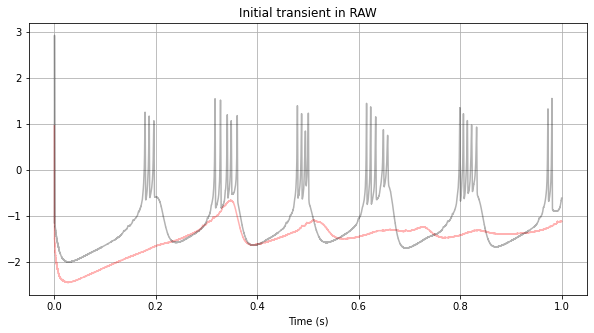

In [5]:
figure(figsize=(10, 5))
plot(raw_time * 1e-3, raw_data[:, 0, 4, 0], "r", alpha=0.3)
plot(raw_time * 1e-3, raw_data[:, 0, 5, 0], "k", alpha=0.3)
title('Initial transient in RAW')
xlabel('Time (s)')
grid(True);